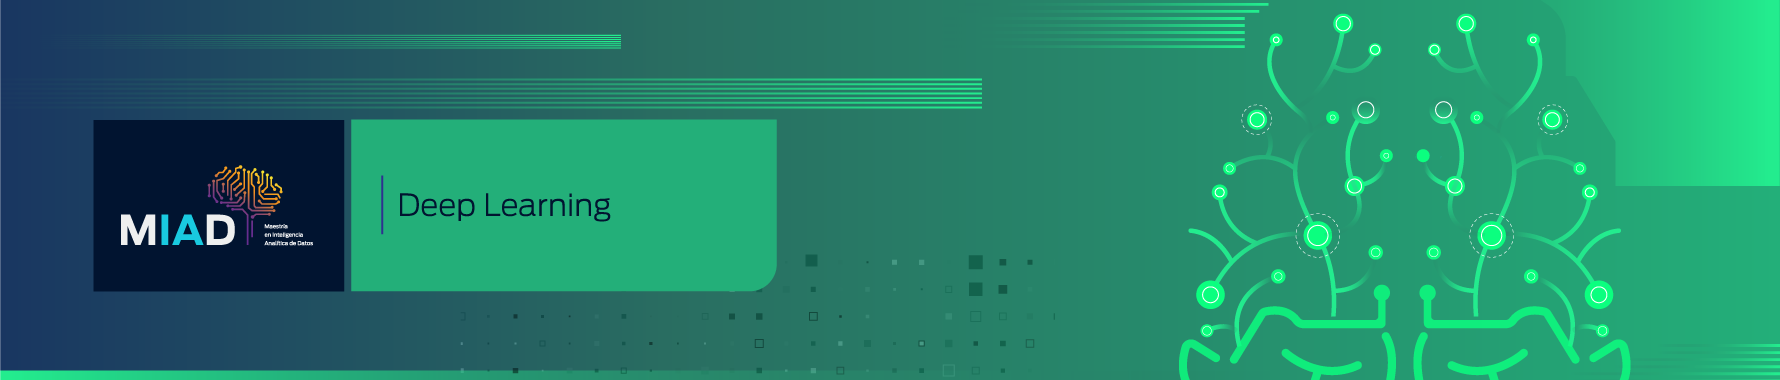

# Deep learning - Semana 7
## Aplicación de GRU (Gated Recurrent Unit) para análisis de sentimiento de texto.

### Propósito

El análisis de sentimiento es una aplicación de procesamiento de lenguaje natural que identifica el tono emocional o la opinión de un texto. Por lo general, las emociones o actitudes hacia un tema pueden ser positivas, negativas o neutrales. Esto convierte al análisis de sentimiento en una tarea de clasificación de texto. En esta actividad se revisará la aplicación del modelo Gated Recurrent Unit (GRU) utilizando el paquete _Keras_, donde se explorará su potencial y capacidad predictiva. Finalmente, habrá una actividad calificada por el personal sobre un conjunto de datos donde deberá calibrar una red GRU.

### Instrucciones generales

1. Para realizar la actividad solo siga las indicaciones asociadas a cada celda del notebook.

2. En las partes iniciales, siéntase libre de modificar el archivo agregando celdas, lo que le permitirá afianzar su comprensión sobre las distintas funcionalidades de código.

### Definición de GRU

Esta red es una versión más simple de LSTM ya que implica el entrenamiento de un menor número de parámetros; sin embargo, es bastante robusta y ha mostrado un gran desempeño en análisis de procesos secuenciales como, por ejemplo, para el análisis de sentimiento de un texto. Comparte la misma idea básica de LSTM, utilizar una serie de puertas (_gates_) para actualizar el estado oculto (_hidden state_) de la red, la cual hace la función de seleccionar qué información del pasado se conserva en el futuro, así como decidir cómo influye la información de entrada que se va ingresando. En el siguiente esquema se puede detallar el modelo:

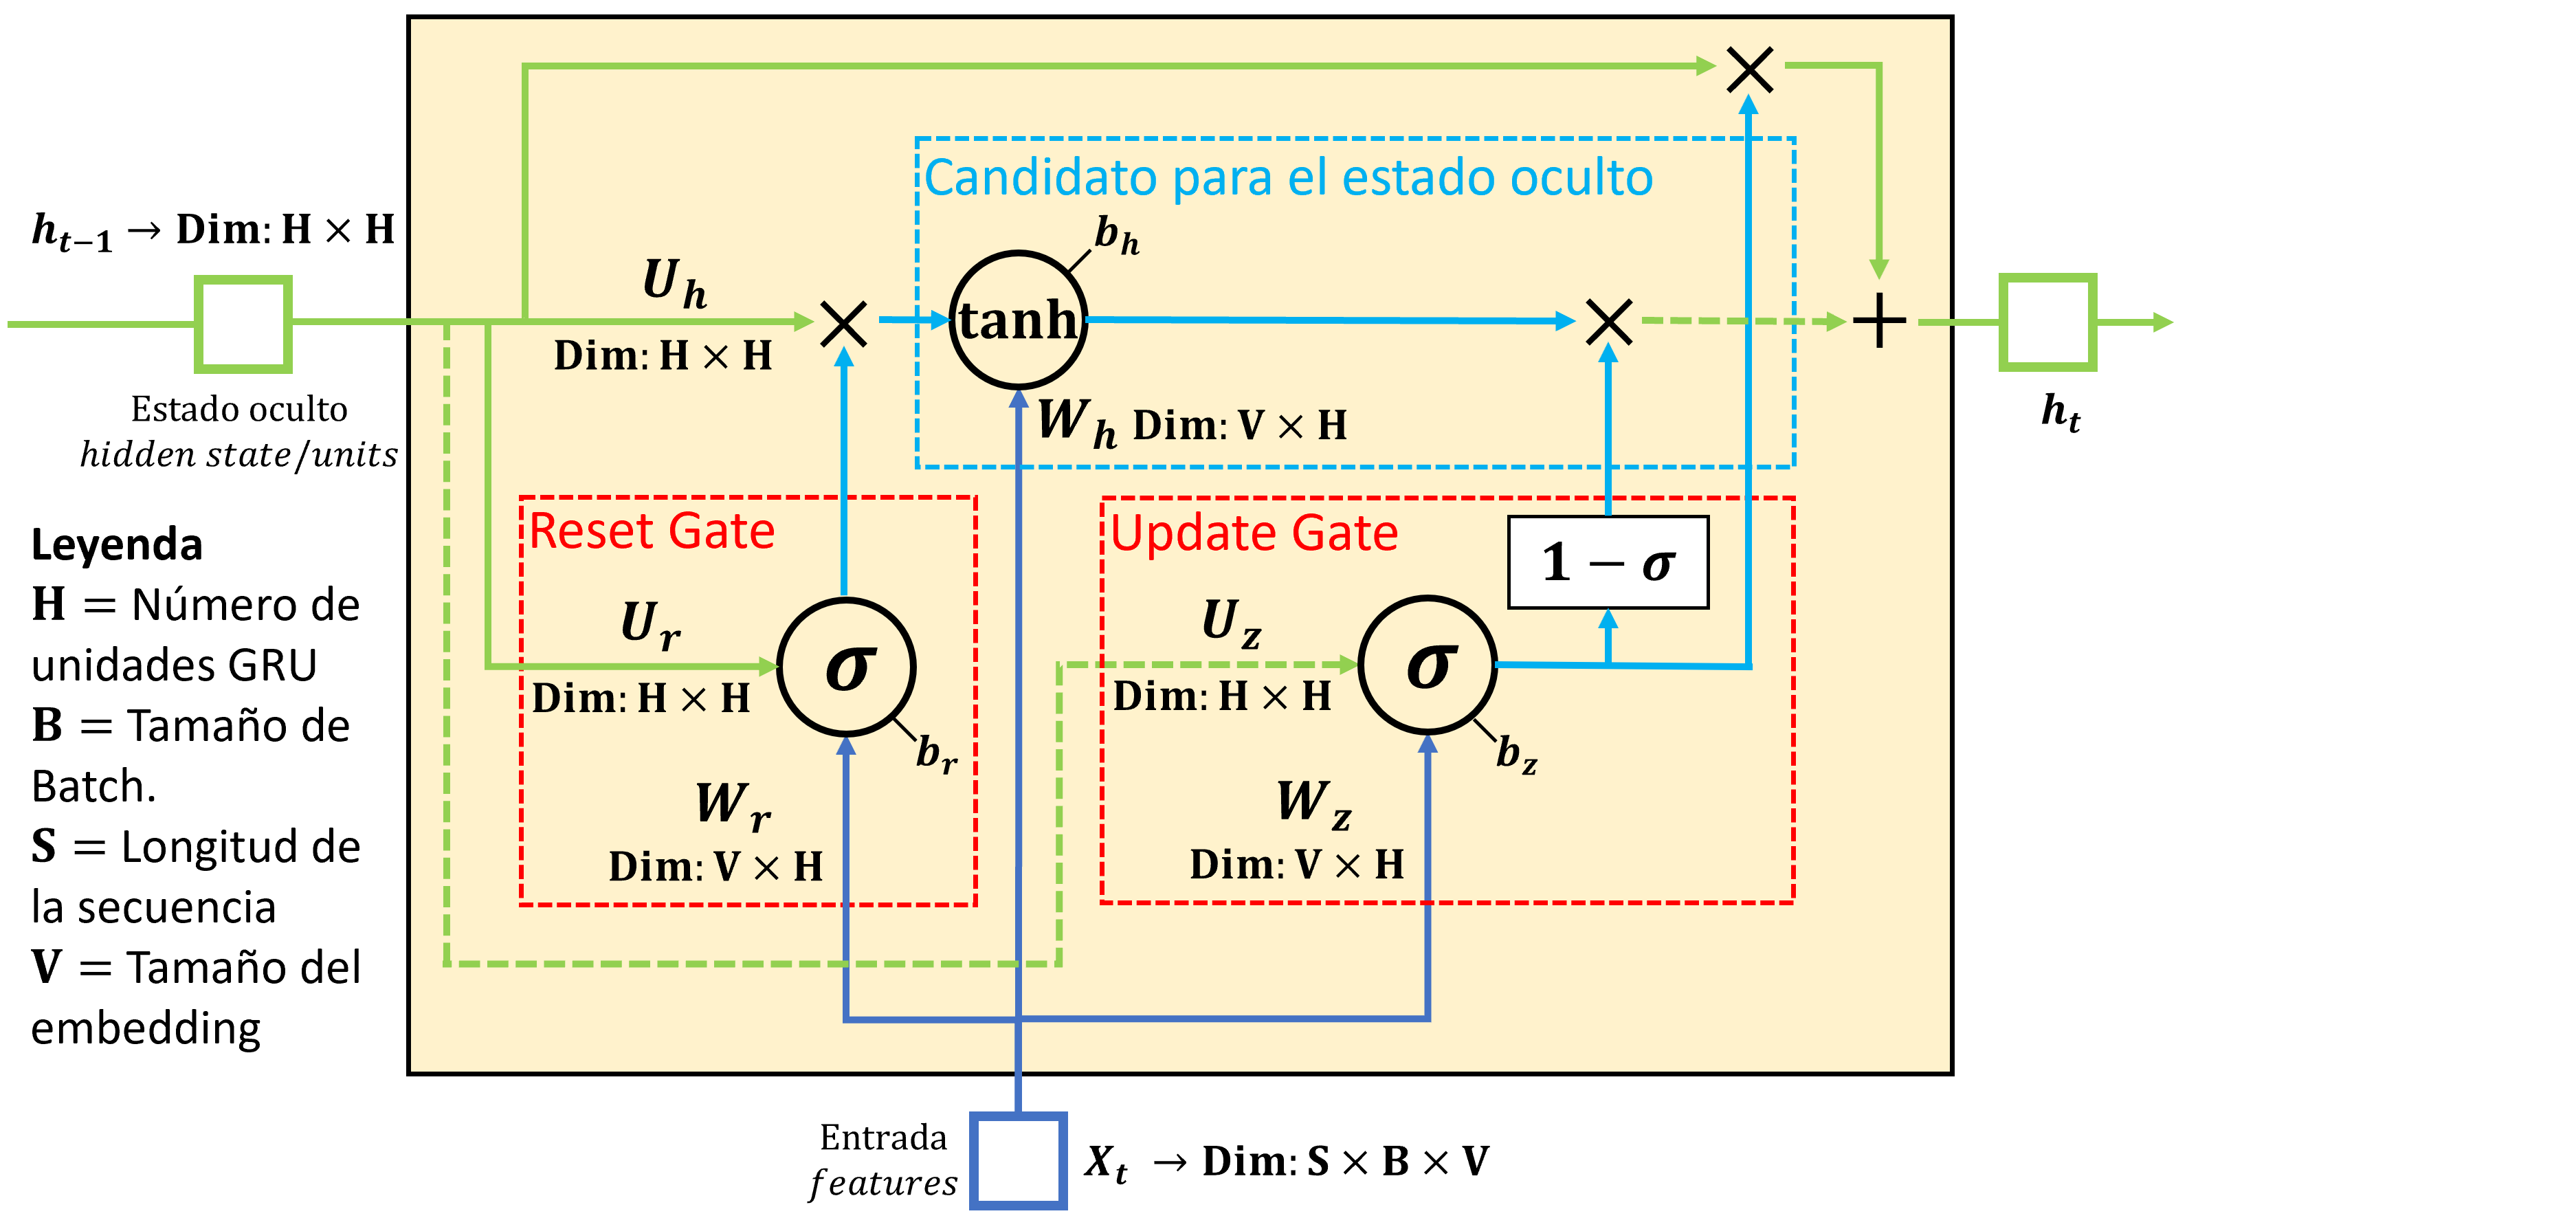

En una celda GRU, se tienen tres puertas que se encargan de decidir el flujo de información:
*   **Puerta de reseteo (_Reset Gate_) $r$:** Determina cuánto conocimiento pasado es olvidado.
*   **Puerta de actualización (_Update Gate_) $z$:** Determina cuánto conocimiento previo necesita ser pasado al futuro.
*   **Puerta de selección de estado (_Current Memory Gate_) $h$:** Determina la información del pasado y actual (de entrada) que será enviada al siguiente estado oculto.

De forma análoga a LSTM, el entrenamiento se puede realizar de forma recursiva concatenando celdas GRU para cada una de las entradas $X_t$. También, es importante notar que cada puerta tiene dos tipos de pesos: con respecto a la entrada se calibran los pesos $W$ que dependen del tamaño de embedding del input y el número de unidades; por otra parte, los pesos $U$ se calibran para los estados ocultos y su cantidad total depende únicamente del número de unidades GRU. Así mismo, cada puerta tiene su número de sesgos. En resumen, el número total de parámetros, teniendo en cuenta las dimensiones del esquema, sigue la ecuación $3\times ((H+V)\times H+2H)$.

### Implementación en Keras/Tensorflow

Para interactuar con los diferentes componentes de la red, implementaremos GRU utilizando la capa que ofrece _Keras_ mediante la aplicación en un ejemplo. En primer lugar, importaremos las librerías requeridas:

In [1]:
import re, os
import math
import pandas as pd
import numpy as np
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
#La siguiente línea evita la generación de "warnings" y "flags" al importar keras y tensorflow.
#Dichas advertencias no comprometen el funcionamiento del código.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#Importación de keras y tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, Dense, Embedding
from keras_preprocessing.text import Tokenizer

In [3]:
data = pd.read_csv('IMDB Dataset.csv')

# Visualizar los primeros registros del DataFrame
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Como estas reseñas provienen de un sitio web, los strings contienen tags de HTML que no interesan para el análisis, por lo que es necesario removerlos. También, es posible que hayan URLs y carácteres no alfanúmericos que no son necesario para comprender el mensaje. La siguiente función elimina estos caracteres y pasa todos los caracteres a minúsculas para simplificar la información.

In [4]:
def remove_tags(string):
    removelist = ""
    p = re.compile(r'<.*?>')
    result = p.sub('',string) #remove HTML tags
    result = re.sub(r'http\S+', '',result) #remove URLs
    result = re.sub(r'[\W_'+removelist+']', ' ', result) #remove non-alphanumeric characters
    result = result.lower()
    return result
data['review']=data['review'].apply(lambda cw : remove_tags(cw))
data

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there s a family where a little boy ...,negative
4,petter mattei s love in the time of money is...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic di...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i m going to have to disagree with the previou...,negative


A diferencia del laboratorio formativo "Redes Neuronales Recurrentes para Procesamiento de Lenguaje Natural (NLP)", donde se buscaba predecir la siguiente palabra en una secuencia, en análisis de sentimiento interesa la emocionalidad del mensaje de la frase en general. Gracias a esto podemos deshacernos de algunas palabras que no aportan significado al mensaje y así reducir el tamaño del corpus y facilitar el entrenamiento. Las palabras que eliminaremos serán las "stopwords", entre las que se encuentran, por ejemplo, preposiciones. El paquete `ntlk` posee una lista con estas palabras que se removerán del corpus:

In [5]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ElkinDavidPeñaRuiz\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Package stopwords is already up-to-date!


,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter mattei love time money visually stunnin...,positive
...,...,...
49995,thought movie right good job creative original...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary schools n...,negative
49998,going disagree previous comment side maltin on...,negative


Ahora, realizaremos la lematización sobre el texto. Esta es una técnica útil para obtener la raiz de las palabras, lo cual se conoce como _lemma_. Así, por ejemplo, podemos asociar todas las conjugaciones de un verbo a una misma palabra (de esta maner, las palabras _reading_, _reads_, _read_ comparte la palabra _read_). Esto reduce el número de palabras a ser entrenadas dejando las que tienen significados distintos que aportan al mensaje. Este proceso se realiza con la función `WordNetLemmatizer()` de `ntlk`. Antes, el texto debe ser dividido en palabras individuales utilizando `WhitespaceTokenizer()` de `ntlk`. La siguiente función realiza la lematización sobre _tokens_ individuales:

In [6]:
nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
data['review'] = data.review.apply(lemmatize_text)
data

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ElkinDavidPeñaRuiz\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Package wordnet is already up-to-date!


,review,sentiment
0,one reviewer mentioned watching 1 oz episode h...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive
...,...,...
49995,thought movie right good job creative original...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,going disagree previous comment side maltin on...,negative


Revisemos algunas estadísticas básicas de las reseñas que nos servirá para decidir algunos hipérparámetros más adelante:

In [7]:
s = 0.0
for i in data['review']:
    word_list = i.split()
    s = s + len(word_list)
print("Longitud promedio de cada reseña : ",s/data.shape[0])
print("Máxima longitud de una reseña: ", len(max(data['review'], key=len)))
pos = 0
for i in range(data.shape[0]):
    if data.iloc[i]['sentiment'] == 'positive':
        pos = pos + 1
neg = data.shape[0]-pos
print("Porcentaje de reseñas con sentimiento positivo: "+str(pos/data.shape[0]*100)+"%")
print("Porcentaje de reseñas con sentimiento negativo: "+str(neg/data.shape[0]*100)+"%")

Longitud promedio de cada reseña :  119.55362
Máxima longitud de una reseña:  9134
Porcentaje de reseñas con sentimiento positivo: 50.0%
Porcentaje de reseñas con sentimiento negativo: 50.0%


Utilizando la función `LabelEncoder()` de `sklearn.preprocessing`, convertimos las etiquetas _positivo_ y _negativo_ en 1s y 0s, respectivamente:

In [8]:
reviews = data['review'].values
labels = data['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

Realizamos la división de los datos por defecto que utiliza `sklearn`, 80% entrenamiento y 20% prueba:

In [9]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels)

Antes de alimentar los datos al modelo GRU, es necesario tokenizar y realizar padding a los datos. Debido al gran número de palabras, puede ser útil limitar el número de palabras del vocabulario, `vocab_size`, en la tokenización. Este sería un parámetro importante a calibrar, donde podemos reducir el consumo de memoria con un vocabulario más pequeño pero estaríamos arriesgando el poder predictivo del modelo:

In [10]:
# Tokenización
vocab_size = 3000
oov_tok = ''
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

Ahora se realiza el padding a las secuencias de texto. Otro hiperparámetro que podemos revisar acá es la longitud máxima de las secuencias. Como ya vimos que el promedio de longitud de una secuencia es 120, usar un máximo de 200 parece reazonable para captar el sentimiento del mensaje. Sin embargo, esto puede no ser suficiente y requerirse series más largas. La longitud del padding afectará directamente la cantidad de parámetros a entrenar, por lo que su selección debe ser cuidadosa en búsqueda de un entrenamiento que no sea excesivamente extenso.

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Padding
max_length = 200
padding_type='post'
trunc_type='post'
# Se convierte la secuencia de train
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# Se convierte la secuencia de test
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

Finalmente, construiremos y entrenaremos el modelo GRU. La primera capa consiste en un "Embedding" que encuentra la vectorización de palabras más útiles para el modelo predictivo, para el cual estableceremos su tamaño con el hiperparámetro `embedding_dim`. Luego de esto, tendremos una capa GRU de 64 unidades, que después se conectará con la capa de salida de función sigmoide que realizará la clasificación de sentimiento. Tenga en cuenta que el modelo se puede demorar varios minutos en correr dependiendo de la arquitectura:

In [12]:
embedding_dim = 100

gru_model = Sequential(name="GRU_Model")
gru_model.add(Embedding(vocab_size,embedding_dim,input_length=max_length))
gru_model.add(GRU(128))
gru_model.add(Dense(1, activation='sigmoid'))

print(gru_model.summary())

gru_model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])

history = gru_model.fit(train_padded, train_labels,batch_size=64, epochs=5,
                        verbose=1, validation_split=0.1)

# Se imprime el valor de la función de pérdida y accuracy sobre el set de Test
print()
print("GRU model Score---> ", gru_model.evaluate(test_padded, test_labels, verbose=0))

Con esta arquitectura se logra un buen desempeño en términos de accuracy, mayor al 85%. Una revisión de la matriz de confusión, gráfica ROC y AUC serían ideales para constatar el desempeño de la red. Para mayores resultados, se pueden agregar capas GRU, capas densas fully-connected luego de las GRU, aumentar el número de unidades por capa o cambiar los parámetros mencionados anteriormente para el _Embedding_.

## Actividad calificada por el personal

Ahora, realice el análisis de sentimiento sobre el conjunto de datos de reseñas de Yelp disponible en [este enlace](https://www.kaggle.com/datasets/ilhamfp31/yelp-review-dataset). Si bien los datos ya están divididos en train y test, no se recomienda usar los datos completos pues son bastantes (560 000 para entrenamiento, 38 000 para prueba) y podría demorar la construcción de su modelo. Se recomienda hacer un _subset_ de al menos 50 000 reseñas del archivo `train.csv` y, a partir de este, dividir los datos con `sklearn` como se hizo en este notebook.

### 1. Preparación de las variables (25 puntos)

Adapte los datos apropiadamente para el uso de las funciones de `keras` y realice la partición de la muestra en entrenamiento, validación y test.

In [43]:
# Definición de las Clases
# 1 = Negativo y 2 = Positivo

# Definir los nuevos encabezados
column_names = ["sentiment", "review"]

data = pd.read_csv('muestra.csv', header=None, names=column_names)
data

,sentiment,review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,You really can't go wrong when you eat here an...
2,2,This place can get pretty busy and with the lo...
3,1,Good food but charges on check were more than ...
4,1,"Loose the annoying, driver distracting sign sp..."
...,...,...
49996,2,Wicked Spoon was my first Vegas buffet experie...
49997,2,"Food-wise, I'm definitely a fan of Technique. ..."
49998,2,"I know this place is still pretty new, but I ..."
49999,1,"I went there with a friend yesterday,totally d..."


In [44]:
# Funciones para limpieza de datos
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def remove_tags(string):
    removelist = ""
    p = re.compile(r'<.*?>')
    result = p.sub('',string) #remove HTML tags
    result = re.sub(r'http\S+', '',result) #remove URLs
    result = re.sub(r'[\W_'+removelist+']', ' ', result) #remove non-alphanumeric characters
    result = result.lower()
    return result

def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ElkinDavidPeñaRuiz\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ElkinDavidPeñaRuiz\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Package wordnet is already up-to-date!


In [49]:
from sklearn.preprocessing import LabelEncoder

# Remover tag
data['review']=data['review'].apply(lambda cw : remove_tags(cw))

# Remover stopwords
data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Lematización del texto
data['review'] = data.review.apply(lemmatize_text)

# Convertir etiquetas a valores numéricos
encoder = LabelEncoder()
data['sentiment'] = encoder.fit_transform(data['sentiment'])

# Dividir los datos en entrenamiento (80%), test (20%)
train_sentences, test_sentences, train_labels, test_labels = train_test_split(data['review'], data['sentiment'],stratify=data['sentiment'], test_size=0.2, random_state=42)

# Tokenización
vocab_size = 2800
oov_tok = ''
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

#Padding
max_length = 180
padding_type='post'
trunc_type='post'
# Se convierte la secuencia de train
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# Se convierte la secuencia de test
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

* Se toma una muestra de 50.001 registros de la base de datos original para el análisis de sentimientos sobre reseñas de Yelp
* Se remueven los tags de HTML, URLs y caracteres no alfanuméricos, dejando todas las palabras en minúsculas.
* Se remueven las stopwords con el fin de limpiar los datos, sacando aquellas palabras que no aportan para predecir el sentimiento y la emoción del mensaje en general, además se reduce el tamaño de los datos para facilitar el entrenamiento.
* Se aplica lematizaición al texto para obtener la raiz de las palabras, reduciendo así el número de palabras eliminando redundancia en los datos.
* Se dividen los datos en entrenamiento (80%) y prueba (20%)
* Se aplica tokenización y padding a los datos para transformarlos antes de pasarselos al modelo GRU, limitando el número de palabras.



### 2. Estimación de un modelo utilizando Gated Recurrent Units (40 puntos)

Estimen un modelo predictivo usando la muestra de entrenamiento y establezcan apropiadamente cada uno de los hiperparámetros de la red.

In [50]:
from keras.layers import Dropout, BatchNormalization

# Definir la dimensión del embedding
embedding_dim = 100

# Crear el modelo GRU
gru_model = Sequential()
gru_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
gru_model.add(GRU(64))
gru_model.add(Dense(1, activation='sigmoid'))

C:\Users\ElkinDavidPeñaRuiz\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [52]:
from keras.callbacks import EarlyStopping

# Definir el callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compilar el modelo con un optimizador Adam con una tasa de aprendizaje más baja
gru_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo con EarlyStopping
history = gru_model.fit(train_padded, train_labels, batch_size=128, epochs=6, verbose=1, validation_split=0.1, callbacks=[early_stopping])

# Evaluar el modelo en el conjunto de validación
print()
print("GRU model Score---> ", gru_model.evaluate(test_padded, test_labels, verbose=0))

Epoch 1/6
282/282 ━━━━━━━━━━━━━━━━━━━━ 76s 248ms/step - accuracy: 0.5254 - loss: 0.6852 - val_accuracy: 0.5378 - val_loss: 0.6751
Epoch 2/6
282/282 ━━━━━━━━━━━━━━━━━━━━ 66s 234ms/step - accuracy: 0.5359 - loss: 0.6812 - val_accuracy: 0.5225 - val_loss: 0.6862
Epoch 3/6
282/282 ━━━━━━━━━━━━━━━━━━━━ 67s 237ms/step - accuracy: 0.5422 - loss: 0.6692 - val_accuracy: 0.7210 - val_loss: 0.6944
Epoch 4/6
282/282 ━━━━━━━━━━━━━━━━━━━━ 68s 242ms/step - accuracy: 0.8229 - loss: 0.4244 - val_accuracy: 0.8888 - val_loss: 0.2824
Epoch 5/6
282/282 ━━━━━━━━━━━━━━━━━━━━ 67s 238ms/step - accuracy: 0.9115 - loss: 0.2319 - val_accuracy: 0.8930 - val_loss: 0.2584
Epoch 6/6
282/282 ━━━━━━━━━━━━━━━━━━━━ 69s 246ms/step - accuracy: 0.9309 - loss: 0.1872 - val_accuracy: 0.9005 - val_loss: 0.2553

GRU model Score--->  [0.25082236528396606, 0.9006099104881287]


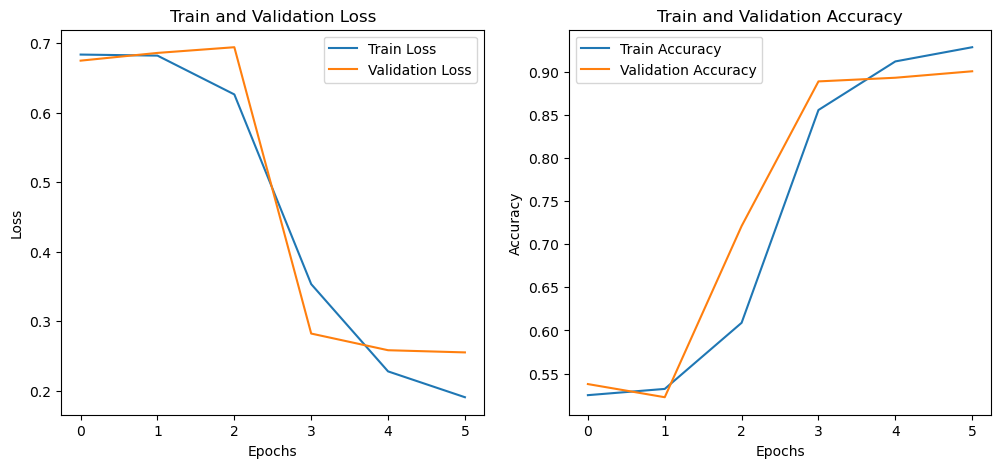

In [53]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

# Mostrar los gráficos
plt.show()

* Se estima un modelo Gated Recurrent Units (GRU) para predecir si el sentimiento de un texto es positivo o negativo.
* Las capas del modelo son las siguientes: Una capa embedding, una capa GRU con 64 unidades y una capa densa con función de activación sigmoide
* El modelo se compiló con la función de perdida binary_crossentropy, optimizador adam y accuracy como métrica de evaluación.
* Se entrena el modelo con 6 épocas y batch_size de 128, logrando un accuracy en train del 93% y en test del 90%
* Se observa un buen desempeño del modelo tanto en train como en test, es decir, está aprendiendo a clasificar con un porcentaje de acierto alto, sin entrar en sobreajuste.

### 3. Calidad de la predicción (35 puntos)

Evalúe el desempeño de su algoritmo con el set de _test_ y argumente sobre el nivel de precisión obtenido, tiempo de ejecución y la arquitectura de su red. Sustente la calidad de la predicción con al menos un análisis sobre el "accuracy", matriz de confusión, gráfica ROC y métrica AUC.

Test Loss: 0.25082236528396606
Test Accuracy: 0.9006099104881287
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90      4988
           1       0.88      0.93      0.90      5013

    accuracy                           0.90     10001
   macro avg       0.90      0.90      0.90     10001
weighted avg       0.90      0.90      0.90     10001

ROC AUC: 0.9644569868142348


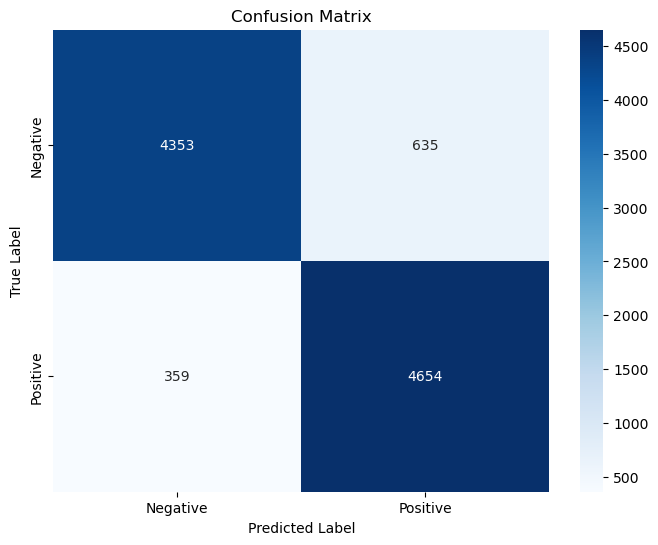

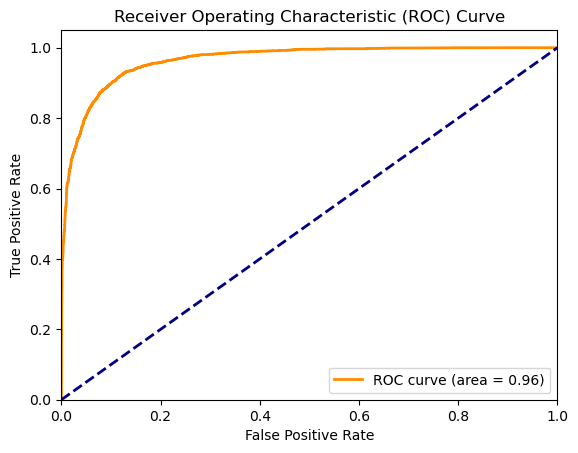

In [56]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Evaluar el modelo en el conjunto de test
test_loss, test_accuracy = gru_model.evaluate(test_padded, test_labels, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predecir las etiquetas para el conjunto de test
test_predictions = gru_model.predict(test_padded)
test_predictions_labels = (test_predictions > 0.5).astype(int)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(test_labels, test_predictions_labels)

# Generar el reporte de clasificación
report = classification_report(test_labels, test_predictions_labels)
print('')
print("Classification Report:")
print(report)

# Calcular la curva ROC y el AUC
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")

# Graficar la matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


* Se evalua la precisión del modelo en test, logrando un accuracy del 90%, de lo cual podemos argumentar que posee un alto poder para predecir si un sentimiento es positivo o negativo dada una reseña.

* En la matriz de confusión se observa un total de 4353 verdaderos negativos, 4654 verdaderos positivos, 359 falsos negativos y 635 falsos negativos.

* El reporte de clasificación muestra una precisión, recall y f1-score de 0.90 tanto para la clase positiva como para la negativa.

* La curva ROC indica un área bajo la curva (AUC) de 0.96, lo que sugiere un buen desempeño del modelo en la clasificación de sentimientos.

* La arquitectura de la red es bastante sencilla con las capas y parámetros mencionados anteriormente que lo hacen eficiente en su entrenamiento, pero con la capacidad suficiente para aprender de los datos debidamente preprocesados y predecir de manera adecuada los sentimientos implicitos en las reseñas.

* Los resultados demuestran que el modelo GRU tiene un alto nivel de precisión y eficacia en la clasificación de reseñas de Yelp, los valores de precisión, recall y f1-score son consistentes y altos. La curva ROC y el AUC de 0.96 confirman la capacidad del modelo para predecir correctamente entre las clases positivas y negativas. Los anteriores resultados sugieren que el modelo es robusto y adecuado para tareas de análisis de sentimiento.